In [33]:
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from tqdm import tqdm

In [34]:
def calc_kinetic_energy(particles: Particles, h: float, tau: float):
    if particles.normalised:
        particles.denormalise(h, tau)
    res = np.sum(particles.v**2)*particles.m*particles.concentration/2
    particles.normalise(h, tau)
    return res

In [35]:
def calc_electric_energy(nodes: Nodes, h: float):
    res = 0
    for i in range(nodes.length-1):
        left = nodes.rho[i]*nodes.phi[i]
        right = nodes.rho[i+1]*nodes.phi[i+1]
        res -= (left+right)/2
    return res


In [36]:
L = 0.01
N_x = 100
N_p = 10000
h = L/N_x
tau = 1e-13

In [37]:
n0 = 1e17
n1 = n0*N_x/N_p
q = 1.60217e-19
m = 9.1093837e-31
epsilon = 8.85e-12

In [38]:
T = 11600
k_b = 1.38e-23
alpha = -m/(2*k_b*T)
v_t = math.sqrt(3*k_b*T/m)
vmin = -10*v_t
vmax = 10*v_t

In [39]:
particles = Particles(N_p, n1, -q, m)
nodes = Nodes(N_x)

In [40]:
set_homogeneous(particles, L/3)

In [41]:
particles.x += L/3

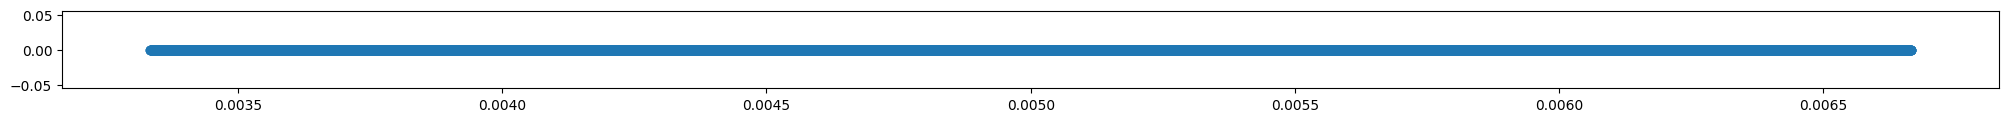

In [42]:
fig, ax = plt.subplots(1, 1)
ax.scatter(particles.x, np.zeros(particles.x.shape))
fig.set_size_inches((25, 1))


In [43]:
set_distr(particles, Maxwell(T, k_b, m), vmin, vmax, 1000)

In [44]:
particles.normalise(h, tau)

In [45]:
particles.v

array([ 3.48518555e-04, -6.24429078e-04,  1.16172852e-04, ...,
        5.80864258e-04,  1.45216065e-05, -1.16172852e-03])

In [46]:
getrho(nodes, particles, periodic=True)

In [47]:
calc_fields(nodes, h, epsilon, periodic=True)

In [48]:
accel(particles, nodes, L, h, tau, zerostep=True)

In [49]:
n = 5000

In [50]:
kinetic_history = []
electric_history = []
summ_history = []

In [51]:
distrs_over_time = []

In [52]:
for t in tqdm(range(n)):
    try:
        move(particles, nodes, mode="periodic", consistency=True)
    except Exception:
        print("number of iteration: ", t)
        break
    getrho(nodes, particles, periodic=True)
    calc_fields(nodes, h, epsilon, periodic=True)
    electric_history.append(calc_electric_energy(nodes, h))
    accel(particles, nodes, L, h, tau)
    distrs_over_time.append(get_distr(particles, 0, 1001))
    kinetic_history.append(calc_kinetic_energy(particles, h, tau))
    

100%|██████████| 5000/5000 [01:23<00:00, 59.89it/s]


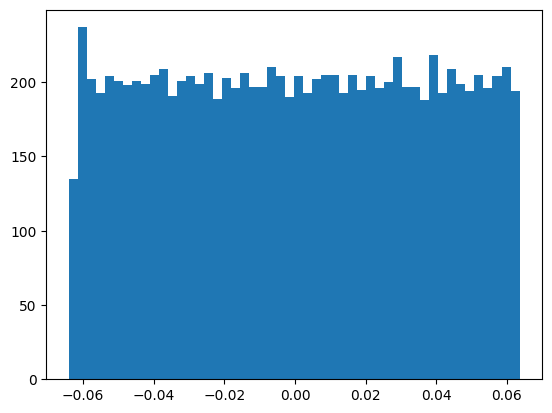

In [53]:
plt.hist(distrs_over_time[400], bins=50)
%matplotlib inline

In [54]:
for i in range(n):
    summ_history.append(kinetic_history[i] + electric_history[i])

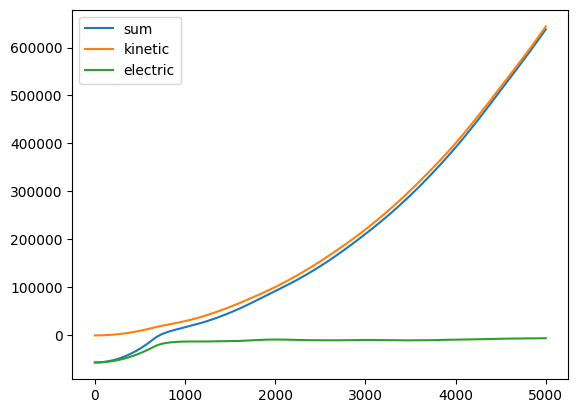

In [55]:
plt.plot(summ_history, label="sum")
plt.plot(kinetic_history, label="kinetic")
plt.plot(electric_history, label="electric")
plt.legend()
plt.show()

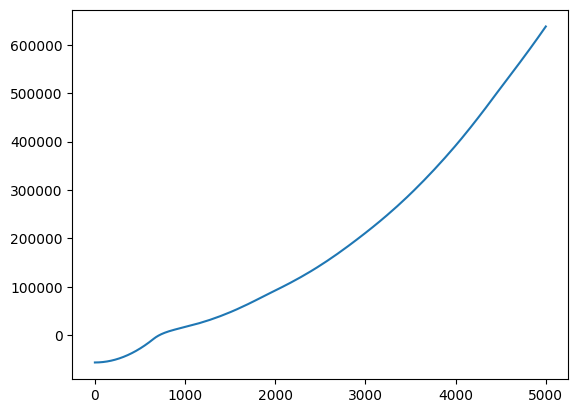

In [56]:
plt.plot(summ_history)


In [298]:
import matplotlib.animation as animation

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

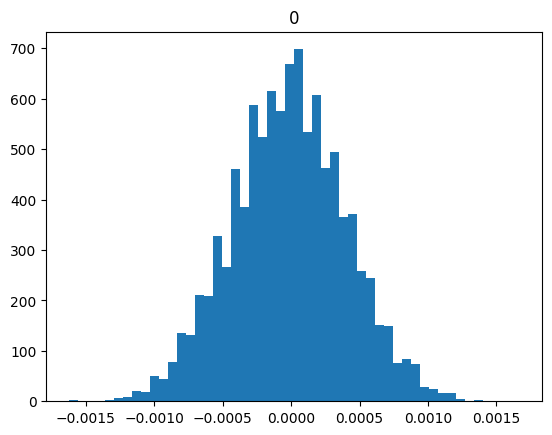

In [299]:
fig, ax = plt.subplots()

#  Создаем функцию, генерирующую картинки
#  для последующей "склейки":
def animate(i):
    ax.clear()
    line = ax.hist(distrs_over_time[i*10], bins=50)
    ax.set_title(str(i*10))
    return line

#  Создаем объект анимации:
sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=range(n),
                                      interval = 5,
                                      repeat = False)

#  Сохраняем анимацию в виде gif файла:
sin_animation.save('distrs_over_time.gif',
                 writer='imagemagick', 
                 fps=30)